In [1]:
import torchvision.models as models
model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
import torch 
import PIL
from PIL import Image 
import torchvision.transforms as transforms
import torch.nn as nn
import sys
import argparse



/Users/kiranmanicka/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kiranmanicka/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kiranmanicka/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1)

    def forward(self, img):
        return (img - self.mean) / self.std



In [3]:
class mod_vgg(nn.Module):
    def __init__(self,model,index):
        super().__init__()
        l=[]
        i=0
        for r in model.children():
            if i==index:
                l.append(nn.Flatten(start_dim=0, end_dim=-1))
            l.append(r)
            i+=1
        self.layers = nn.ModuleList(l)
        

    def forward(self, x):
        for r  in self.layers:
            x=r(x)
        return x




In [4]:
content_directory='content'
style_directory='style'

content_image = Image.open(f'{content_directory}/booth.jpeg') 
style_image=Image.open(f'{style_directory}/starry.jpeg')

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    
]) 
  
content_tensor = transform(content_image)
style_tensor=transform(style_image)

mod_model=mod_vgg(model,2)


content_loss_index=8
style_loss_indices=[1,3,6,8,11]


temp_layers=list(list(list(mod_model.children())[0].children())[0])
temp_layers.insert(0,Normalization())




In [5]:
def get_activations(image):
    base_content_activation=None
    base_style_activation=[]
    for r in range(len(temp_layers)):
        image=temp_layers[r](image)
        if r==content_loss_index:
            base_content_activation=image.clone()
        if r in style_loss_indices:
            base_style_activation.append(image.clone())
            if style_loss_indices[-1]==r:
                break
    return base_content_activation,base_style_activation

model.requires_grad_(False)
for r in temp_layers:
    r.requires_grad_(False)

base_content,_=get_activations(content_tensor)
_,base_style=get_activations(style_tensor)



In [6]:
def calc_gram_matrix(feature_maps):
    a,b,c=feature_maps.size()
    features = feature_maps.view(a, b*c)
    G = torch.mm(features, features.t())
    #return G
    return G.div(a * b * c)
    
#     return tensor

base_gram_matrices=[calc_gram_matrix(r) for r in base_style]

base_content=base_content.detach()
for r in range(len(base_style)):
    base_style[r]=base_style[r].detach()




In [7]:
def overall_loss(img,content, style,base_content,base_style,version='both',variation=True):
    def total_variation_loss(img, weight):
        c_img, h_img, w_img = img.size()
        tv_h = torch.pow(img[:,1:,:]-img[:,:-1,:], 2).sum()
        tv_w = torch.pow(img[:,:,1:]-img[:,:,:-1], 2).sum()
        return weight*(tv_h+tv_w)/(c_img*h_img*w_img)
    if variation:
        variation_loss=total_variation_loss(img,1000000)
    else:
        torch.tensor(0)
    style_loss=nn.MSELoss()
    content_loss=nn.MSELoss()
    alpha=1
    beta=100000
    style_loss_tensor=torch.tensor(0)
    content_loss_tensor=torch.tensor(0)
    for r in range(len(base_style)):
        style_loss_tensor=style_loss_tensor+ style_loss(calc_gram_matrix(style[r]),base_gram_matrices[r])
    
    content_loss_tensor=content_loss(content,base_content)
    if version=='style':
        return style_loss_tensor+variation_loss
    if version=='content':
        return content_loss_tensor+variation_loss
    
    return alpha*content_loss_tensor + beta * style_loss_tensor



iteration:  0


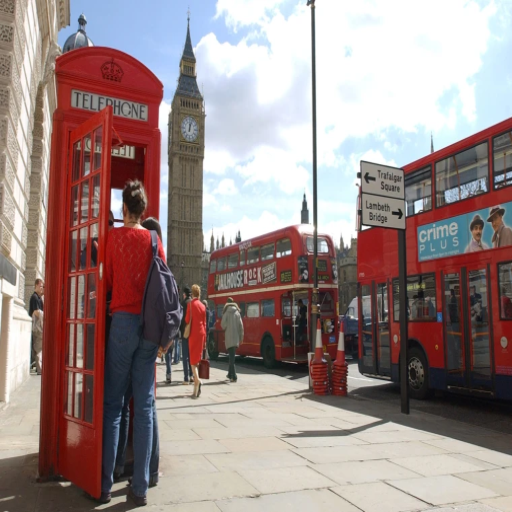

iteration:  100


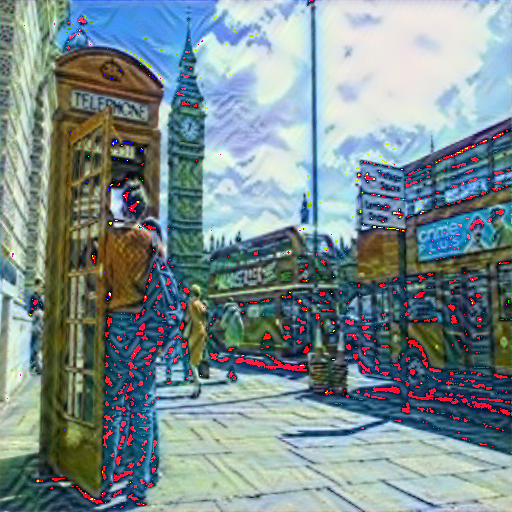

iteration:  200


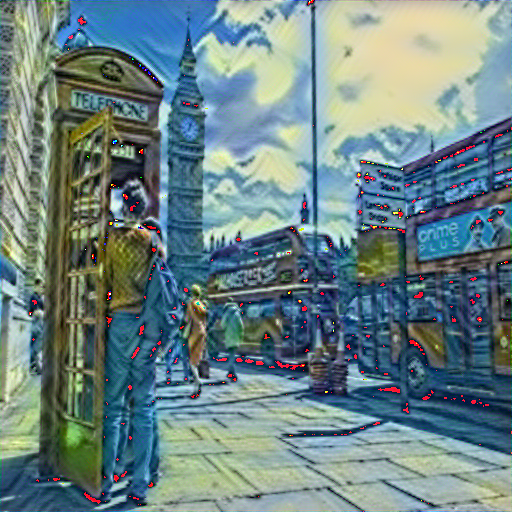

In [8]:
iterations=300

import torch.optim as optim

generated_image=content_tensor.clone()
generated_image.requires_grad=True

LBFGS_optimizer=optim.LBFGS([generated_image])
optimizer=optim.SGD([generated_image],lr=.1)

test_clone=generated_image.clone().detach()
threshold=0
i=[0]
invTrans = transforms.Compose([ 
                                transforms.ToPILImage()
                                
                               ])

while i[0]<iterations:
    # making predictions with forward pass
    if i[0]% 100==0:
        print('iteration: ',i[0])
        inversed_image=invTrans(generated_image.clone())
        display(inversed_image)
    def closure():
        with torch.no_grad():
            generated_image.clamp_(0, 1)
        i[0]+=1
        content,style=get_activations(generated_image)
        # calculating the loss between original and predicted data points
        computed_loss=overall_loss(generated_image,content,style,base_content,base_style,"both",variation="False")
        LBFGS_optimizer.zero_grad()
        computed_loss.backward()
        return computed_loss
    # updateing the parameters after each iteration
    LBFGS_optimizer.step(closure)

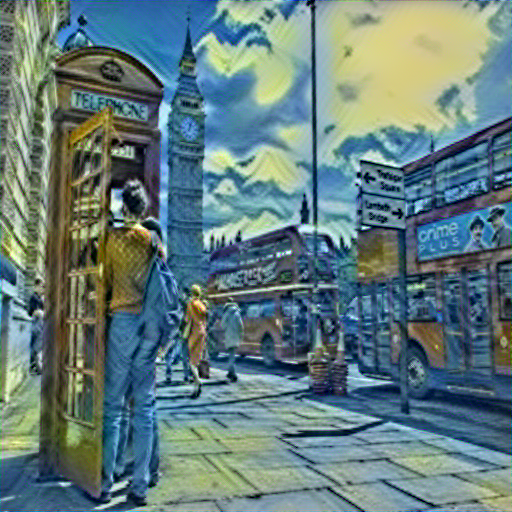

In [9]:
with torch.no_grad():
    generated_image.clamp_(0, 1)

inversed_image=invTrans(generated_image.clone())
display(inversed_image)